<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-maze" data-toc-modified-id="Create-a-maze-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a maze</a></span><ul class="toc-item"><li><span><a href="#Randomized-Prim's-algorithm" data-toc-modified-id="Randomized-Prim's-algorithm-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Randomized Prim's algorithm</a></span></li><li><span><a href="#Completely-random-maze" data-toc-modified-id="Completely-random-maze-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Completely random maze</a></span></li></ul></li><li><span><a href="#Construct-adjacency-matrix" data-toc-modified-id="Construct-adjacency-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct adjacency matrix</a></span></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

# Adjacency matrix for a maze

In [3]:
from abc import ABC, abstractmethod
from collections import deque
import heapq
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx
import numpy as np

In [4]:
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams['animation.html'] = 'html5'

In [5]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, networkx, np]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.10.0 (default, Oct  8 2021, 16:27:24) [GCC 8.3.0]
Packages:
    matplotlib: 3.4.3
    networkx: 2.6.3
    numpy: 1.21.2


## Create a maze

A maze acts here as a proxy for a *n*-dimensional energy function `f(*args) -> E`.

Mazes as NumPy ndarrays are composed of cells which are either 0 (wall/high energy/inaccessible) or 1 (passage/low energy/accessible). Indexing into the array, simulates an energy calculation for a given state in the state space. A maze like this has no entrance or exit and can have periodic boundaries.

### Randomized Prim's algorithm

Ensures the creation of a random contiguous maze with short dead ends.

Layout of the algorithm (grow the maze outward through random frontier cells):

  - Start with a maze of unassigned cells
  - Pick a starting cell and mark it as part of the maze
  - Mark the neighbouring cells of the starting cell as walls and add them to the list of walls (frontier)
  - As long as there are walls in the wall list:
     - Take a random wall out of the list
     - If the wall has an unassigned cell on the opposite side of a maze cell:
        - Turn the wall into a part of the maze
        - Mark the unassigned cell as part of the maze
        - Mark the unassigned neighbouring cells of the two assigned cells as walls and add them to the list of walls

In [6]:
class Energy(ABC):
    """Potential energy function representation"""

    @abstractmethod
    def get_energy(cell: tuple) -> float:
        """Calculate the energy of a given state"""

In [49]:
class Maze(Energy):
    """Special potential energy realisation

    Uses a pre-generated maze a (binary) proxy for
    potential energy calculations.

    Args:
        maze: An *n*-dimensional maze (:class:`numpy.ndarray`).
    """

    KW_MAKE_MAP = {
        "prim": "_make_maze_prim",
    }

    def __init__(self, maze=None):
        self.maze = maze

    def __repr__(self):
        return f"{type(self).__name__}()"

    def __str__(self):
        if self.maze is None:
            return []

        return str(self.maze)

    def _check_algorithm(self, algorithm):
        try:
            make_func = self.__getattribute__(self.KW_MAKE_MAP.get(algorithm, algorithm))
        except AttributeError:
            raise ValueError(
                    f"Invalid algorithm {algorithm}. "
                    f"Must be one of {list(self.KW_MAKE_MAP.keys())}"
                    )
        return make_func

    def make(self, algorithm="prim", size=None):
        make_func = self._check_algorithm(algorithm)
        self.maze = next(make_func(size=size))

    def make_animate_2d(
            self,
            algorithm="prim",
            size=None, interval=1,
            imshow_props=None, animate_props=None,
            ax=None, ax_props={}):

        if len(size) != 2:
            raise ValueError("Can only animate two dimensional mazes.")

        make_func = self._check_algorithm(algorithm)

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()

        default_imshow_props = {
            "vmin": -1,
            "vmax": 1,
            "cmap": mpl.cm.inferno
        }
        if imshow_props is not None:
            default_imshow_props.update(imshow_props)

        default_animate_props = {
            "blit": True,
            "interval": 50,
            "repeat": False,
            "save_count": np.prod(size)
        }
        if animate_props is not None:
            default_animate_props.update(animate_props)

        default_ax_props = {
            "xticks": (),
            "yticks": (),
        }
        if ax_props is not None:
            default_ax_props.update(ax_props)

        maze_states = make_func(size=size, interval=interval)
        im = ax.imshow(next(maze_states), **default_imshow_props)

        ax.set(**default_ax_props)

        def init():
            im.set_data(next(maze_states))
            return im,

        def update(i):
            im.set_array(i)
            return im,

        animation = mpl.animation.FuncAnimation(
            fig, update, init_func=init,
            frames=maze_states, **default_animate_props
            )

        # self.maze = im.get_array()

        return animation

    def _make_maze_prim(self, size=None, interval=None):
        """Create a maze using a variation of the randomized Prim's algorithm

        Uses periodic boundaries in all dimensions.

        Cells have values corresponding to

          * wall: 1
          * passage: 0
          * unassigned: -1

        Note:
           This gives a maze on a multi-dimensional grid in which
           a cell can either be a wall (inaccessible) or part of
           the maze (accessible). All neighbouring accessible cells
           are connected. The maze is *not* a minimal spanning tree
           over all cells!

           This kind of maze is different to for example a maze on
           a graph in which all cells (nodes) are part of the maze
           and connected by either a passage or a wall (edges).

        Keyword args:
            size (tuple of integers): Shape of the created maze.
            interval: If not `None`, yields the state in intervals
                of this many creation steps.

        Returns:
           Maze as numpy.ndarray
        """

        def get_neighbouring_cell_pairs(cell):
            for i, coordinate in enumerate(cell):
                yield (
                    (*cell[:i], (cell[i] + 1) % size[i], *cell[i + 1:]),
                    (*cell[:i], (cell[i] - 1) % size[i], *cell[i + 1:])
                    )

        def get_neighbouring_cells(cell, condition=None):
            for i, coordinate in enumerate(cell):
                for neighbour_coordinate in [
                        (cell[i] + 1) % size[i],
                        (cell[i] - 1) % size[i]]:

                    neighbour_cell = (*cell[:i], neighbour_coordinate, *cell[i + 1:])
                    if (condition is None) | (maze[neighbour_cell] == condition):
                        yield neighbour_cell

        def make_wall(cell):
            maze[cell] = 1
            wall_list.append(cell)

        def grow(cell, next_cell):
            maze[cell] = 0
            maze[next_cell] = 0
            for neighbour in get_neighbouring_cells(next_cell, condition=-1):
                make_wall(neighbour)

        if size is None:
            size = (2, 2)

        maze = np.full(size, -1, dtype=int)

        if interval is not None:
            yield maze

        wall_list = []

        cell = tuple(np.random.randint(0, s) for s in size)
        maze[cell] = 0

        for neighbour in get_neighbouring_cells(cell):
            make_wall(neighbour)

        if interval is not None:
            yield maze

        n_steps = 1
        while wall_list:
            random.shuffle(wall_list)
            cell = wall_list.pop()

            for cell_a, cell_b in get_neighbouring_cell_pairs(cell):
                state_a, state_b = (
                    maze[c] for c in [cell_a, cell_b]
                    )

                if (state_a == -1) & (state_b == 0):
                    grow(cell, cell_a)
                    break

                elif (state_b == -1) & (state_a == 0):
                    grow(cell, cell_b)
                    break

            for neighbour in get_neighbouring_cells(cell, condition=-1):
                make_wall(neighbour)

            if (interval is not None) and (n_steps % interval == 0):
                yield maze
            n_steps += 1

        if (interval is None) or (n_steps % interval != 0):
            yield maze

    def get_energy(self, cell: tuple):
        return self.maze[cell]

    def pick_first_accessible_cell(self):
        if self.maze is None:
            return

        for cell in np.ndindex(self.maze.shape):
            if self.maze[cell] == 0:
                return cell

    def pick_random_accessible_cell(self):
        if self.maze is None:
            return

        while True:
            cell = tuple(np.random.randint(0, s) for s in self.maze.shape)
            if self.maze[cell] == 0:
                return cell

In [50]:
maze = Maze()
maze

Maze()

In [7]:
maze.make(size=(20, 20))
print(maze)

[[1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1]
 [1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1]
 [1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0]
 [1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
 [1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1]
 [0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0]
 [1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0]
 [1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0]
 [1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0]
 [1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0]
 [1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0]
 [0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0]]


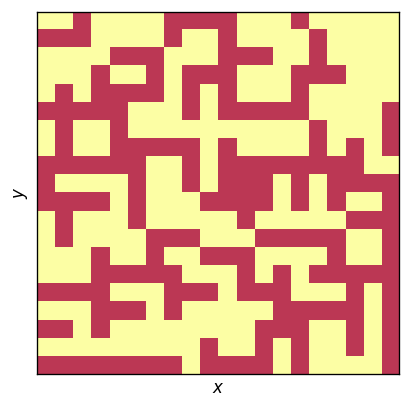

In [8]:
plt.close("all")
fig, ax = plt.subplots()
im = ax.imshow(
    maze.maze, vmin=-1, vmax=1,
    cmap=mpl.cm.inferno
)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})
plt.show()

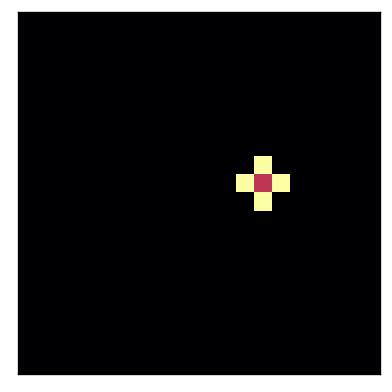

In [9]:
animation = maze.make_animate_2d(size=(20, 20))

In [10]:
animation

In [11]:
cell = maze.pick_accessible_cell()
cell

(0, 2)

In [12]:
maze.get_energy(cell)

0

### Completely random maze

Not ideal. It is very probable that the maze has more than one connected component.

In [7]:
rng = np.random.default_rng(11)
maze = rng.integers(0, 2, size=(10, 10))

In [8]:
maze

array([[0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 1]])

In [9]:
maze[np.array([1, 2, 3])]

array([[0, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])

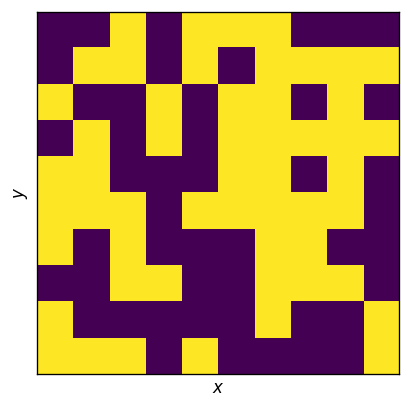

In [10]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(maze)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})
plt.show()

## Construct adjacency matrix

Given an energy function (a maze), pick an accessible starting state and explore the respective connected component using graph-traversal/maze-exploration algorithms:

  - breadth-first-search (BFS)
  
Construct an adjacency matrix for the subset of states in the explored component.

In [97]:
class Explorer:
    """State space exploration

    An :class:`Explorer` tries to find the energetically
    accessible state space based on a potential energy function.

    Args:
        energy: An instance of :class:`Energy`.
        bounds (Sequence): A sequence (:class:`numpy.ndarray`).
            Extend of the state space in each dimension. Used as periodic
            boundaries.
        delta (Sequence): A sequence (:class:`numpy.ndarray`).
            Increment to find neighbouring states in each dimension
            (resolution of the grid).
        energy_cutoff: Accessible states have to lie lower than this energy.
    """

    def __init__(
            self, energy, bounds, delta, energy_cutoff, graph=None):

        self.energy = energy
        self.bounds = bounds
        self.delta = delta
        self.energy_cutoff = energy_cutoff
        self.graph = graph

    def __repr__(self):
        return (
            f"{type(self).__name__}("
            f"energy={self.energy!r}, bounds={self.bounds}, "
            f"delta={self.delta}, energy_cutoff={self.energy_cutoff})"
            )

    def get_neighbouring_cells(self, cell):
        """Yield neighbouring cells

        Determines the neighbouring states of a state (cell) in state
        space discretised by a grid based on :obj:`self.bounds` and :obj:`self.delta`.

        Args:
           cell (tuple): Coordinates of a state.

        Yields:
           Neighbouring cells as (tuples of indices)
        """

        for i, coordinate in enumerate(cell):
            for neighbour_coordinate in [
                    (cell[i] + self.delta[i]) % self.bounds[i],
                    (cell[i] - self.delta[i]) % self.bounds[i]]:

                neighbour_cell = (*cell[:i], neighbour_coordinate, *cell[i + 1:])
                yield neighbour_cell

    def explore_bfs(self, cell):
        """Construct a graph for a set of connected accessible cells

        Args:
            cell: An accessible cell from which to start the exploration

        Returns:
            The graph of accessible cells (:class:`networkx.Graph`)
        """

        self.graph = graph = networkx.Graph()
        graph.add_node(
            0,
            cell=cell,
            energy=self.energy.get_energy(cell)
            )

        queue = deque()
        queue.append(0)

        visited = set()
        visited.add(cell)

        while queue:
            cell_id = queue.popleft()
            cell = graph.nodes[cell_id]["cell"]

            for neighbour in self.get_neighbouring_cells(cell):
                if neighbour in visited:
                    continue

                visited.add(neighbour)

                cell_energy = self.energy.get_energy(neighbour)
                if cell_energy > self.energy_cutoff:
                    continue

                neighbour_id = graph.number_of_nodes()

                queue.append(neighbour_id)
                graph.add_node(
                    neighbour_id,
                    cell=neighbour,
                    energy=cell_energy
                )
                graph.add_edge(cell_id, neighbour_id)

    def explore_dijkstra(self, cell, target):

        self.graph = graph = networkx.Graph()
        graph.add_node(
            0,
            cell=cell,
            energy=self.energy.get_energy(cell)
            )

        queue = []
        heapq.heappush(queue, (0., 0))

        prev = [0]
        distances = [0]
        added = {cell: 0}
        done = set()

        while queue:
            distance, cell_id = heapq.heappop(queue)
            cell = graph.nodes[cell_id]["cell"]

            if cell == target:
                current = cell_id
                path = [current]

                while current != 0:
                    current = prev[current]
                    path.append(current)
                return path

            if cell in done:
                continue

            done.add(cell)

            for i, neighbour in enumerate(self.get_neighbouring_cells(cell)):

                if neighbour in done:
                    continue

                cell_energy = self.energy.get_energy(neighbour)
                if cell_energy > self.energy_cutoff:
                    done.add(neighbour)
                    continue

                neighbour_id = added.get(neighbour, None)
                distance += self.delta[i // 2]
                if neighbour_id is None:
                    neighbour_id = graph.number_of_nodes()
                    added[neighbour] = neighbour_id

                    graph.add_node(
                        neighbour_id,
                        cell=neighbour,
                        energy=cell_energy
                    )
                    graph.add_edge(cell_id, neighbour_id)
                    prev.append(cell_id)
                    distances.append(distance)
                else:
                    if distance < distances[neighbour_id]:
                        distances[neighbour_id] = distance
                        prev[neighbour_id] = cell_id

                heapq.heappush(queue, (distance, neighbour_id))

        return


In [98]:
maze = Maze()
maze.make(size=(20, 20))

explorer = Explorer(
    energy=maze,
    bounds=maze.maze.shape,
    delta=np.ones_like(maze.maze.shape),
    energy_cutoff=0.5
)

In [99]:
explorer

Explorer(energy=Maze(), bounds=(20, 20), delta=[1 1], energy_cutoff=0.5)

In [83]:
start = explorer.energy.pick_first_accessible_cell()
explorer.explore_bfs(start)

In [84]:
explorer.graph.number_of_nodes()

189

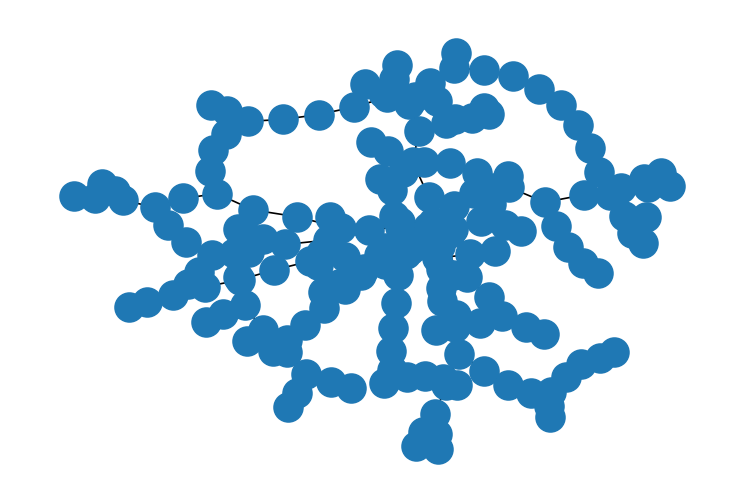

In [41]:
networkx.draw(explorer.graph)

In [42]:
def adjacency_matrix_from_graph(graph):
    """Transform connectivity information in a graph into an adjacency matrix"""

    matrix = np.zeros(
        (graph.number_of_nodes(), graph.number_of_nodes()),
        dtype=int
        )

    for i, j in graph.edges:
        matrix[i, j] = matrix[j, i] = 1

    return matrix

In [43]:
adj_matrix = adjacency_matrix_from_graph(explorer.graph)

In [44]:
adj_matrix.shape

(185, 185)

In [45]:
adj_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [46]:
# Check if everthing is correct
for node, data in explorer.graph.nodes(data=True):
    assert maze.maze[data["cell"]] == 0

    i = node

    for edge in explorer.graph.edges(node):
        j = edge[1]

        neighbour = explorer.graph.nodes[j]["cell"]
        assert maze.maze[neighbour] == 0

        assert adj_matrix[i, j] == adj_matrix[j, i] == 1

assert np.count_nonzero(adj_matrix) == 2 * explorer.graph.number_of_edges()

### Dijkstra

In [100]:
start = explorer.energy.pick_random_accessible_cell()
end = explorer.energy.pick_random_accessible_cell()

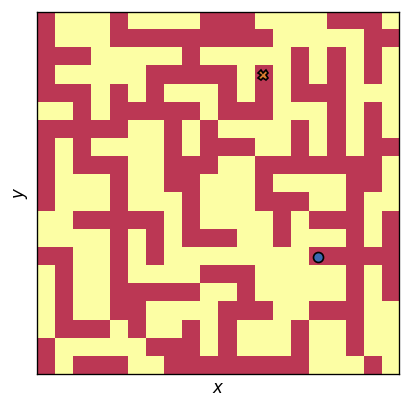

In [106]:
plt.close("all")
fig, ax = plt.subplots()
im = ax.imshow(
    maze.maze, vmin=-1, vmax=1,
    cmap=mpl.cm.inferno,
)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})

ax.plot(start[1], start[0], marker="o", markeredgecolor="k")
ax.plot(end[1], end[0], marker="X", markeredgecolor="k")
plt.show()

In [102]:
path = explorer.explore_dijkstra(start, end)

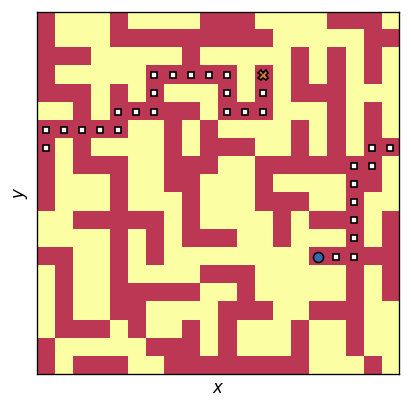

In [107]:
plt.close("all")
fig, ax = plt.subplots()
im = ax.imshow(
    maze.maze, vmin=-1, vmax=1,
    cmap=mpl.cm.inferno,
)
ax.set(**{
    "xlabel": "$x$",
    "ylabel": "$y$",
    "xticks": (),
    "yticks": (),
})

for cell_id in path:
    cell = explorer.graph.nodes[cell_id]["cell"]
    ax.plot(
        cell[1], cell[0],
        marker="s", markerfacecolor="w", markeredgecolor="k",
        markersize=4
        )

ax.plot(start[1], start[0], marker="o", markeredgecolor="k")
ax.plot(end[1], end[0], marker="X", markeredgecolor="k")
plt.show()

## Scratch

In [ ]:
matrix = np.zeros((3, 3))
for i in np.ndindex(matrix.shape):
    print(i)